[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gulierus/SU2_HR-net/blob/main/tracking_benchmark_laptrack_gt.ipynb)

---

# CCP Tracking Benchmark: LapTrack (Ground Truth Data)

This notebook benchmarks **LapTrack** (Linear Assignment Problem tracking) using ground truth detections from validation data.

**Key Features:**
- Uses GT detections (no model inference)
- **Focused parameter sweep** based on prior knowledge (best: track=7px, gap=5px, frames=2)
- Comprehensive visualizations
- HOTA metric evaluation

**Focused Parameter Grid:**
- `track_cost_cutoff`: [5, 6, 7, 8] px (centered on best=7px)
- `gap_closing_cost_cutoff`: [4, 5, 6, 7] px (centered on best=5px)
- `gap_closing_max_frame_count`: [1, 2, 3] (best=2)
- **Total: 48 combinations**

**Algorithm:** LapTrack uses transformer-based tracking that won ISBI 2024 Cell Tracking Challenge

**Dataset:** Real TIRF-SIM microscopy validation data with ground truth annotations

In [ ]:
# @title Help functions

import torch
import numpy as np
import pandas as pd
import math
from typing import List, Tuple, Optional, Dict, Any
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage import measure
from scipy import ndimage as ndi
from scipy import spatial, optimize
from dataclasses import dataclass
import json
import os
from tqdm.auto import tqdm
import random
import matplotlib.pyplot as plt
import zipfile
import sys

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================================
# DETECTOR
# ============================================================================
@dataclass
class DetectionParams:
    threshold: float = 0.5
    min_area: int = 5
    nms_min_dist: Optional[float] = None

class CCPDetector:
    """
    CCP detector using trained U-Net++ model.
    Includes Test Time Augmentation (TTA) and Watershed segmentation.
    """
    def __init__(self, model, device=DEVICE, params: Optional[DetectionParams] = None):
        self.model = model.to(device)
        self.device = device
        self.params = params if params is not None else DetectionParams()
        self.model.eval()

    def detect(self, image: np.ndarray) -> Tuple[np.ndarray, List[Tuple[int, int]]]:
        if image.ndim == 3:
            img_base = image[0]
        else:
            img_base = image

        rotations = [
            img_base,
            np.rot90(img_base, k=1),
            np.rot90(img_base, k=2),
            np.rot90(img_base, k=3)
        ]

        batch_tensors = [torch.from_numpy(r.copy()).float().unsqueeze(0) for r in rotations]
        batch = torch.stack(batch_tensors).to(self.device)

        with torch.no_grad():
            outputs = self.model(batch)
            outputs = torch.sigmoid(outputs)
            preds = outputs.cpu().numpy()

        p0 = preds[0, 0]
        p90 = np.rot90(preds[1, 0], k=-1)
        p180 = np.rot90(preds[2, 0], k=-2)
        p270 = np.rot90(preds[3, 0], k=-3)

        avg_map = (p0 + p90 + p180 + p270) / 4.0
        mask = (avg_map > self.params.threshold).astype(float)
        detections = self.extract_detections(mask)

        return mask, detections

    def extract_detections(self, mask: np.ndarray) -> List[Tuple[int, int]]:
        mask_bool = mask.astype(bool)
        if not np.any(mask_bool):
            return []

        distance = ndi.distance_transform_edt(mask_bool)
        min_dist = self.params.nms_min_dist if self.params.nms_min_dist is not None else 3
        local_maxi = peak_local_max(distance, min_distance=min_dist, labels=mask_bool, exclude_border=False)
        markers = np.zeros(distance.shape, dtype=int)
        markers[local_maxi[:, 0], local_maxi[:, 1]] = np.arange(len(local_maxi)) + 1
        labels = watershed(-distance, markers, mask=mask_bool)

        detections = []
        for region in measure.regionprops(labels):
            if region.area >= self.params.min_area:
                y, x = region.centroid
                detections.append((int(x), int(y)))
        return detections

# ============================================================================
# TRACKING HELPERS
# ============================================================================
def link_detections(detections_per_frame: List[List[Tuple[int, int]]], max_dist: float = 7.0) -> pd.DataFrame:
    next_track_id = 0
    active_tracks = {}
    records = []

    for frame_idx, detections in enumerate(detections_per_frame):
        assigned = [False] * len(detections)
        detection_track_id = [None] * len(detections)
        updated_tracks = {}

        for track_id, (tx, ty, last_frame) in list(active_tracks.items()):
            best_dist = max_dist
            best_idx = None
            for i, (x, y) in enumerate(detections):
                if assigned[i]: continue
                dist = math.hypot(x - tx, y - ty)
                if dist < best_dist:
                    best_dist = dist
                    best_idx = i

            if best_idx is not None:
                assigned[best_idx] = True
                detection_track_id[best_idx] = track_id
                updated_tracks[track_id] = (detections[best_idx][0], detections[best_idx][1], frame_idx)

        for i, (x, y) in enumerate(detections):
            if not assigned[i]:
                track_id = next_track_id
                next_track_id += 1
                detection_track_id[i] = track_id
                updated_tracks[track_id] = (x, y, frame_idx)

        active_tracks = updated_tracks
        for i, (x, y) in enumerate(detections):
            tid = detection_track_id[i]
            records.append({'frame': frame_idx, 'x': x, 'y': y, 'track_id': tid})

    return pd.DataFrame(records)

@dataclass
class BTrackParams:
    max_search_radius: float = 20.0
    do_optimize: bool = True
    dist_thresh: float = 10.0
    time_thresh: int = 3
    segmentation_miss_rate: float = 0.1
    apoptosis_rate: float = 0.0
    allow_divisions: bool = False
    min_track_len: int = 5
    gap_closing_max_frame_count: int = 3
    out_config_path: str = "cell_config_custom.json"

def build_btrack_config(params: BTrackParams) -> str:
    from btrack import datasets as btrack_datasets
    base_cfg_path = btrack_datasets.cell_config()
    with open(base_cfg_path, "r") as f:
        cfg = json.load(f)

    hyp = cfg.get("hypothesis_model", {})
    hyp["dist_thresh"] = params.dist_thresh
    hyp["time_thresh"] = params.time_thresh
    hyp["segmentation_miss_rate"] = params.segmentation_miss_rate
    hyp["apoptosis_rate"] = params.apoptosis_rate

    if not params.allow_divisions and "hypotheses" in hyp:
        hyp["hypotheses"] = [h for h in hyp["hypotheses"] if "DIVIDE" not in h.upper()]

    cfg["hypothesis_model"] = hyp

    out_path = params.out_config_path
    with open(out_path, "w") as f:
        json.dump(cfg, f, indent=2)
    return out_path

def track_with_btrack(detections_per_frame, val_roi, btrack_params: Optional[BTrackParams] = None):
    import btrack
    from btrack import BayesianTracker

    if btrack_params is None:
        btrack_params = BTrackParams()

    objects = []
    for t, dets in enumerate(detections_per_frame):
        for x, y in dets:
            obj = btrack.btypes.PyTrackObject()
            obj.x = float(x)
            obj.y = float(y)
            obj.z = 0.0
            obj.t = t
            objects.append(obj)

    config_file = build_btrack_config(btrack_params)

    with BayesianTracker() as tracker:
        tracker.configure(config_file)
        tracker.max_search_radius = float(btrack_params.max_search_radius)
        tracker.volume = ((0, val_roi.shape[2]), (0, val_roi.shape[1]), (-1e5, 1e5))
        tracker.append(objects)
        tracker.track()
        if btrack_params.do_optimize:
            tracker.optimize()
        data, properties, graph = tracker.to_napari(ndim=2)

    tracks_df = pd.DataFrame(data, columns=["track_id", "frame", "y", "x"])

    # Filter by min_track_len
    if not tracks_df.empty:
        track_counts = tracks_df['track_id'].value_counts()
        valid_tracks = track_counts[track_counts >= btrack_params.min_track_len].index
        tracks_df = tracks_df[tracks_df['track_id'].isin(valid_tracks)]

    return tracks_df[["frame", "x", "y", "track_id"]]


# ============================================================================
# LAPTRACK TRACKING
# ============================================================================
@dataclass
class LapTrackParams:
    """
    Parameters for LapTrack (Linear Assignment Problem) tracking.

    LapTrack uses graph-based optimization for linking detections across frames.
    It's particularly good at handling:
    - Dense scenes with many particles
    - Temporary occlusions (gap closing)
    - Variable particle velocities
    """
    max_distance: float = 15.0              # Max linking distance between frames
    track_cost_cutoff: float = 15.0         # Cost cutoff for linking
    gap_closing_max_frame_count: int = 2    # Max frames to close gaps
    gap_closing_cost_cutoff: float = 15.0   # Cost cutoff for gap closing
    min_track_len: int = 5                  # Minimum track length to keep

def track_with_laptrack(
    detections_per_frame: List[List[Tuple[int, int]]],
    params: Optional[LapTrackParams] = None
) -> pd.DataFrame:
    """
    Track detections using LapTrack (Linear Assignment Problem tracking).

    LapTrack uses graph-based optimization to link detections across frames,
    providing robust tracking even in dense scenes with occlusions.

    Args:
        detections_per_frame: List of detections per frame, each as [(x, y), ...]
        params: LapTrack parameters (uses defaults if None)

    Returns:
        DataFrame with columns ['frame', 'x', 'y', 'track_id']
    """
    try:
        from laptrack import LapTrack
        import networkx as nx
    except ImportError:
        raise ImportError(
            "LapTrack not installed. Install with: pip install laptrack"
        )

    if params is None:
        params = LapTrackParams()

    if len(detections_per_frame) == 0:
        return pd.DataFrame(columns=['frame', 'x', 'y', 'track_id'])

    # Prepare coordinate array per frame
    coords_per_frame = []
    for frame_idx, dets in enumerate(detections_per_frame):
        if len(dets) > 0:
            coords = np.array([[x, y] for x, y in dets])
        else:
            coords = np.empty((0, 2))
        coords_per_frame.append(coords)

    # Initialize LapTrack
    tracker = LapTrack(
        track_cost_cutoff=params.track_cost_cutoff,
        gap_closing_cost_cutoff=params.gap_closing_cost_cutoff,
        gap_closing_max_frame_count=params.gap_closing_max_frame_count,
    )

    # Run tracking - returns networkx DiGraph
    graph = tracker.predict(coords_per_frame)

    # Extract tracks from graph
    # Nodes are tuples (frame_idx, det_idx)
    # Connected components = tracks
    records = []

    # Get weakly connected components (each component is one track)
    for track_id, component in enumerate(nx.weakly_connected_components(graph)):
        for node in component:
            frame_idx, det_idx = node
            if frame_idx < len(coords_per_frame) and det_idx < len(coords_per_frame[frame_idx]):
                x, y = coords_per_frame[frame_idx][det_idx]
                records.append({
                    'frame': frame_idx,
                    'x': x,
                    'y': y,
                    'track_id': track_id
                })

    track_df = pd.DataFrame(records)

    # Sort by frame
    if not track_df.empty:
        track_df = track_df.sort_values(['track_id', 'frame']).reset_index(drop=True)

        # Filter by min track length
        if params.min_track_len > 1:
            track_counts = track_df['track_id'].value_counts()
            valid_tracks = track_counts[track_counts >= params.min_track_len].index
            track_df = track_df[track_df['track_id'].isin(valid_tracks)]

    return track_df[["frame", "x", "y", "track_id"]]


# ============================================================================
# METRICS
# ============================================================================
def hota(gt: pd.DataFrame, tr: pd.DataFrame, threshold: float = 5) -> dict[str, float]:
    """
    Calculate HOTA metrics for tracking evaluation.
    """
    # Ensure particle ids are sorted from 0 to max(n)
    gt = gt.copy()
    tr = tr.copy()

    if gt.empty:
        return {'HOTA': 0.0, 'AssA': 0.0, 'DetA': 0.0, 'LocA': 0.0}
    if tr.empty:
        return {'HOTA': 0.0, 'AssA': 0.0, 'DetA': 0.0, 'LocA': 0.0}

    gt.track_id = gt.track_id.map({old: new for old, new in
                                   zip(gt.track_id.unique(), range(gt.track_id.nunique()))})
    tr.track_id = tr.track_id.map({old: new for old, new in
                                   zip(tr.track_id.unique(), range(tr.track_id.nunique()))})

    # Initialization
    num_gt_ids = gt.track_id.nunique()
    num_tr_ids = tr.track_id.nunique()

    frames = sorted(set(gt.frame.unique()) | set(tr.frame.unique()))

    potential_matches_count = np.zeros((num_gt_ids, num_tr_ids))
    gt_id_count = np.zeros((num_gt_ids, 1))
    tracker_id_count = np.zeros((1, num_tr_ids))

    HOTA_TP, HOTA_FN, HOTA_FP = 0, 0, 0
    LocA = 0.0

    # Compute similarities (inverted normalized distance)
    similarities = [1 - np.clip(spatial.distance.cdist(gt[gt.frame == t][['x', 'y']],
                                                       tr[tr.frame == t][['x', 'y']]) / threshold, 0, 1)
                    for t in frames]

    # Accumulate global track information
    for t_idx, t in enumerate(frames):
        gt_ids_t = gt[gt.frame == t].track_id.to_numpy()
        tr_ids_t = tr[tr.frame == t].track_id.to_numpy()

        if len(gt_ids_t) == 0 or len(tr_ids_t) == 0:
            continue

        similarity = similarities[t_idx]
        sim_iou_denom = similarity.sum(0)[np.newaxis, :] + similarity.sum(1)[:, np.newaxis] - similarity
        sim_iou = np.zeros_like(similarity)
        sim_iou_mask = sim_iou_denom > 0 + np.finfo('float').eps
        sim_iou[sim_iou_mask] = similarity[sim_iou_mask] / sim_iou_denom[sim_iou_mask]
        potential_matches_count[gt_ids_t[:, None], tr_ids_t[None, :]] += sim_iou

        gt_id_count[gt_ids_t] += 1
        tracker_id_count[0, tr_ids_t] += 1

    global_alignment_score = potential_matches_count / (gt_id_count + tracker_id_count - potential_matches_count)
    matches_count = np.zeros_like(potential_matches_count)

    # Calculate scores for each timestep
    for t_idx, t in enumerate(frames):
        gt_ids_t = gt[gt.frame == t].track_id.to_numpy()
        tr_ids_t = tr[tr.frame == t].track_id.to_numpy()

        if len(gt_ids_t) == 0:
            HOTA_FP += len(tr_ids_t)
            continue

        if len(tr_ids_t) == 0:
            HOTA_FN += len(gt_ids_t)
            continue

        similarity = similarities[t_idx]
        score_mat = global_alignment_score[gt_ids_t[:, None], tr_ids_t[None, :]] * similarity

        match_rows, match_cols = optimize.linear_sum_assignment(-score_mat)

        actually_matched_mask = similarity[match_rows, match_cols] > 0
        alpha_match_rows = match_rows[actually_matched_mask]
        alpha_match_cols = match_cols[actually_matched_mask]

        num_matches = len(alpha_match_rows)

        HOTA_TP += num_matches
        HOTA_FN += len(gt_ids_t) - num_matches
        HOTA_FP += len(tr_ids_t) - num_matches

        if num_matches > 0:
            LocA += sum(similarity[alpha_match_rows, alpha_match_cols])
            matches_count[gt_ids_t[alpha_match_rows], tr_ids_t[alpha_match_cols]] += 1

    ass_a = matches_count / np.maximum(1, gt_id_count + tracker_id_count - matches_count)
    AssA = np.sum(matches_count * ass_a) / np.maximum(1, HOTA_TP)
    DetA = HOTA_TP / np.maximum(1, HOTA_TP + HOTA_FN + HOTA_FP)
    HOTA_score = np.sqrt(DetA * AssA)

    return {
        'HOTA': HOTA_score,
        'AssA': AssA,
        'DetA': DetA,
        'LocA': LocA,
        'HOTA TP': HOTA_TP,
        'HOTA FN': HOTA_FN,
        'HOTA FP': HOTA_FP
    }

def run_tracking_on_validation(
    model,
    val_input=None,
    tracking_method="btrack",
    detection_params: Optional[DetectionParams] = None,
    btrack_params: Optional[BTrackParams] = None,
    laptrack_params: Optional[LapTrackParams] = None,
    y_min=512, y_max=768, x_min=256, x_max=512,
    use_validation_data=False,
    show_visualization=False
):
    # Load validation data if requested
    val_gt = None
    if use_validation_data:
        val_tif_path = "/content/val_data/val.tif"
        val_csv_path = "/content/val_data/val.csv"

        if os.path.exists(val_tif_path):
            val_input = open_tiff_file(val_tif_path).astype(np.float64)

        if os.path.exists(val_csv_path):
            val_gt = pd.read_csv(val_csv_path)
            # Filter GT to ROI
            val_gt = val_gt.groupby('track_id').filter(
                lambda t: (y_min < t.y.mean() < y_max) and (x_min < t.x.mean() < x_max)
            )

    if val_input is None:
        raise ValueError("val_input must be provided or use_validation_data=True with valid paths.")

    val_roi = val_input[:, y_min:y_max, x_min:x_max]

    # Initialize detector with params
    detector = CCPDetector(model, device=DEVICE, params=detection_params)

    # print("Detecting CCPs...")
    detections_per_frame = []
    # Use tqdm only if visualization is on or for single run, to avoid spamming logs during sweep
    iterator = range(len(val_roi))
    if show_visualization:
        iterator = tqdm(iterator, desc="Detecting")

    for frame_idx in iterator:
        frame = val_roi[frame_idx]
        frame_norm = (frame - frame.mean()) / (frame.std() + 1e-8)
        mask, detections = detector.detect(frame_norm)
        detections_per_frame.append(detections)

    # print(f"Linking with {tracking_method}...")
    if tracking_method == "btrack":
        tracks_df = track_with_btrack(detections_per_frame, val_roi, btrack_params)
    elif tracking_method == "laptrack":
        tracks_df = track_with_laptrack(detections_per_frame, laptrack_params)
    else:
        tracks_df = link_detections(detections_per_frame)

    # Adjust coordinates back to full image
    tracks_df['x'] += x_min
    tracks_df['y'] += y_min

    results = {}
    if val_gt is not None and not tracks_df.empty:
        results = hota(val_gt, tracks_df)

    return tracks_df, results

def set_seed(seed=42):
    """Sets the seed for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def plot_training_history(history):
    """Plots training and validation loss and dice score."""
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Dice
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_dice'], 'g-', label='Val Dice')
    plt.title('Validation Dice Score')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

def download_and_unzip(url, extract_to, chain_path=None):
    """Downloads a zip file and extracts it."""
    import requests

    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    zip_path = os.path.join(extract_to, "temp.zip")

    print(f"Downloading {url}...")
    # Use the certificate chain if provided
    verify = chain_path if chain_path else True

    try:
        r = requests.get(url, stream=True, verify=verify)
        r.raise_for_status()
        with open(zip_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

        print("Extracting...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)

        os.remove(zip_path)
        print("Done!")
    except requests.exceptions.SSLError as e:
        print(f"SSL Error: {e}")
        print("Try providing the correct certificate chain path.")
    except Exception as e:
        print(f"Error: {e}")

def patch_dataloader():
    """
    Patches torch.utils.data.DataLoader to fix RecursionError by forcing persistent_workers=True.
    This is a workaround for a specific issue in some environments.
    """
    print("Attempting to fix RecursionError by retrieving clean DataLoader...")

    # 1. Identify the DataLoader class currently in memory
    TargetDataLoader = torch.utils.data.DataLoader

    # 2. Obtain a CLEAN, unpatched __init__ method by forcing a fresh import
    # We temporarily remove the submodule from sys.modules to bypass the cache
    if 'torch.utils.data.dataloader' in sys.modules:
        del sys.modules['torch.utils.data.dataloader']

    try:
        # Import a fresh copy of the module
        from torch.utils.data.dataloader import DataLoader as CleanDataLoader
        clean_init = CleanDataLoader.__init__
        print("Success: Retrieved a clean, unpatched __init__ method.")
    except ImportError:
        # Fallback if the internal structure is different
        print("Warning: Could not force reload. Trying to unwrap if possible.")
        clean_init = TargetDataLoader.__init__
        while hasattr(clean_init, '__wrapped__'):
            clean_init = clean_init.__wrapped__

    # 3. Define the patch using the CLEAN init
    def patched_dataloader_init(self, *args, **kwargs):
        # Apply the fix: force persistent_workers=True if num_workers > 0
        if kwargs.get('num_workers', 0) > 0 and 'persistent_workers' not in kwargs:
            kwargs['persistent_workers'] = True
            print(f"[INFO] Patched DataLoader for {self}: persistent_workers=True")

        # Call the clean original init
        clean_init(self, *args, **kwargs)

    # 4. Apply the patch to the existing DataLoader class object
    TargetDataLoader.__init__ = patched_dataloader_init

    print("Fixed: torch.utils.data.DataLoader has been successfully patched.")


def open_tiff_file(filepath):
    """
    Load a TIFF file (single or multi-frame) as numpy array.

    Args:
        filepath: Path to TIFF file

    Returns:
        numpy array with shape (frames, height, width) for multi-frame
        or (height, width) for single frame
    """
    try:
        # Try tifffile first (best for scientific TIFF)
        import tifffile
        return tifffile.imread(filepath)
    except ImportError:
        # Fallback to PIL
        from PIL import Image
        img = Image.open(filepath)

        # Handle multi-frame TIFF
        frames = []
        try:
            i = 0
            while True:
                img.seek(i)
                frames.append(np.array(img))
                i += 1
        except EOFError:
            pass

        if len(frames) == 1:
            return frames[0]
        else:
            return np.array(frames)

# ============================================================================
# MODEL SAVING UTILITIES
# ============================================================================

def save_model_to_drive(model, save_dir, model_name="hrnet", save_best=True):
    """
    Save trained model to Google Drive or local directory.

    Args:
        model: PyTorch model to save
        save_dir: Directory to save model
        model_name: Base name for saved files (default: "hrnet")
        save_best: Whether to also copy best_model.pth if it exists

    Returns:
        final_path: Path where final model was saved
    """
    import torch
    import shutil

    os.makedirs(save_dir, exist_ok=True)

    # Save final model
    final_path = os.path.join(save_dir, f"{model_name}_final.pth")
    torch.save(model.state_dict(), final_path)
    print(f"✓ Final model saved to: {final_path}")

    # Save best model if exists
    if save_best and os.path.exists('best_model.pth'):
        best_path = os.path.join(save_dir, f"{model_name}_best.pth")
        shutil.copy('best_model.pth', best_path)
        print(f"✓ Best model saved to: {best_path}")

    return final_path

## Configuration

In [ ]:
# @title Configuration

import os
import sys

print("="*70)
print("CCP Tracking Benchmark - LapTrack with Ground Truth Data")
print("="*70)

CONFIG = {
    'VAL_DATA_DIR': '/content/val_data',
    'VAL_TIF_PATH': '/content/val_data/val.tif',
    'VAL_CSV_PATH': '/content/val_data/val.csv',

    # ROI for evaluation
    'ROI': {
        'y_min': 512,
        'y_max': 768,
        'x_min': 256,
        'x_max': 512
    },

    # Focused sweep parameters based on prior knowledge
    # Best known: track=7px, gap=5px, frames=2
    'SWEEP_TRACK_DISTANCES': [5, 6, 7, 8],      # Centered on 7px best, ±2px
    'SWEEP_GAP_DISTANCES': [4, 5, 6, 7],        # Centered on 5px best, ±2px
    'SWEEP_GAP_FRAMES': [1, 2, 3],              # 2 was best, check 1 and 3

    # Output
    'OUTPUT_DIR': '/content/benchmark_results_laptrack',
    'SAVE_GIFS': True,
    'SAVE_CSV': True
}

# Create output directory
os.makedirs(CONFIG['OUTPUT_DIR'], exist_ok=True)

print(f"Focused sweep parameters (based on prior knowledge):")
print(f"  Track distances: {CONFIG['SWEEP_TRACK_DISTANCES']}px (best=7px)")
print(f"  Gap distances: {CONFIG['SWEEP_GAP_DISTANCES']}px (best=5px)")
print(f"  Gap frames: {CONFIG['SWEEP_GAP_FRAMES']} (best=2)")
total_combos = len(CONFIG['SWEEP_TRACK_DISTANCES']) * len(CONFIG['SWEEP_GAP_DISTANCES']) * len(CONFIG['SWEEP_GAP_FRAMES'])
print(f"  Total combinations: {total_combos}")
print(f"Output: {CONFIG['OUTPUT_DIR']}")
print("="*70)

## 🔧 Setup Environment

In [ ]:
# @title Setup Environment

import os # Added: Import os module
import sys

print("\n[1/5] Setting up environment...")

# Mount Google Drive
is_colab = False
try:
    from google.colab import drive
    print("  Mounting Google Drive...")
    drive.mount('/content/drive')
    is_colab = True
    print("  ✓ Google Drive mounted")
except ImportError:
    print("  Not running on Colab, skipping Drive mount")

# Install dependencies
print("\n[2/5] Installing dependencies...")
print("  Installing LapTrack (requires pydantic>=2) and compatible Scipy...")
!pip install -q "laptrack==0.17.0" "scipy==1.14.1" seaborn
print("  ✓ Dependencies installed")

# Import modules
print("\n[4/5] Importing modules...")
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.collections as mc
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize
import seaborn as sns
from tqdm.auto import tqdm
import itertools
from datetime import datetime
from scipy.spatial.distance import cdist
from scipy import spatial, optimize
from PIL import Image
from laptrack import LapTrack

print(f"  ✓ All modules imported")
print(f"  LapTrack version: {LapTrack.__module__}")

# Download validation data
print("\n[5/5] Checking validation data...")
if not os.path.exists(CONFIG['VAL_DATA_DIR']):
    print("  Downloading validation data...")
    import requests
    import zipfile

    # Download SSL certificate
    chain_path = "/content/chain-harica-cross.pem"
    cert_url = "https://pki.cesnet.cz/_media/certs/chain-harica-rsa-ov-crosssigned-root.pem"
    r = requests.get(cert_url, timeout=10)
    r.raise_for_status()
    with open(chain_path, "wb") as f:
        f.write(r.content)

    # Download validation data
    zip_url = "https://su2.utia.cas.cz/files/labs/final2025/val_and_sota.zip"
    local_zip = "val_and_sota.zip"

    print(f"  Downloading {local_zip}...")
    response = requests.get(zip_url, stream=True, verify=chain_path, timeout=60)
    response.raise_for_status()
    with open(local_zip, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"  Extracting to '{CONFIG['VAL_DATA_DIR']}'...")
    os.makedirs(CONFIG['VAL_DATA_DIR'], exist_ok=True)
    with zipfile.ZipFile(local_zip, "r") as zip_ref:
        zip_ref.extractall(CONFIG['VAL_DATA_DIR'])
    os.remove(local_zip)
    print("  ✓ Validation data downloaded")
else:
    print(f"  ✓ Validation data exists at {CONFIG['VAL_DATA_DIR']}")

print("\n" + "="*70)
print(" SETUP COMPLETE")
print("="*70)


[1/5] Setting up environment...
  Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  ✓ Google Drive mounted

[2/5] Installing dependencies...
  Installing LapTrack (requires pydantic>=2) and compatible Scipy...
  ✓ Dependencies installed

[4/5] Importing modules...
  ✓ All modules imported
  LapTrack version: laptrack._tracking

[5/5] Checking validation data...
  Extracting to '/content/val_data'...
  ✓ Validation data downloaded

 SETUP COMPLETE


## Define Helper Functions

In [ ]:
# @title Helper Functions

def open_tiff_file(name: str) -> np.ndarray:
    """Load multi-frame TIFF file"""
    img = Image.open(name)
    frames = []
    for i in range(img.n_frames):
        img.seek(i)
        frames.append(np.array(img))
    return np.array(frames).squeeze()

def track_with_laptrack(detections_per_frame, track_cost_cutoff=25.0,
                        gap_closing_cost_cutoff=25.0, gap_closing_max_frame_count=2):
    """
    Track detections using LapTrack.

    Args:
        detections_per_frame: List of detections per frame, each detection is (x, y)
        track_cost_cutoff: Cost cutoff for linking (squared distance)
        gap_closing_cost_cutoff: Cost cutoff for gap closing (squared distance)
        gap_closing_max_frame_count: Maximum number of frames to close gaps

    Returns:
        DataFrame with columns: frame, x, y, track_id
    """
    from laptrack import LapTrack
    import networkx as nx

    if len(detections_per_frame) == 0:
        return pd.DataFrame(columns=['frame', 'x', 'y', 'track_id'])

    # Prepare coordinate array per frame
    coords_per_frame = []
    for frame_idx, dets in enumerate(detections_per_frame):
        if len(dets) > 0:
            coords = np.array([[x, y] for x, y in dets])
        else:
            coords = np.empty((0, 2))
        coords_per_frame.append(coords)

    # Initialize LapTrack
    tracker = LapTrack(
        track_cost_cutoff=track_cost_cutoff,
        gap_closing_cost_cutoff=gap_closing_cost_cutoff,
        gap_closing_max_frame_count=gap_closing_max_frame_count,
    )

    try:
        # Run tracking - returns networkx DiGraph
        graph = tracker.predict(coords_per_frame)

        # Extract tracks from graph
        records = []

        # Get weakly connected components (each component is one track)
        for track_id, component in enumerate(nx.weakly_connected_components(graph)):
            for node in component:
                frame_idx, det_idx = node
                if frame_idx < len(coords_per_frame) and det_idx < len(coords_per_frame[frame_idx]):
                    x, y = coords_per_frame[frame_idx][det_idx]
                    records.append({
                        'frame': int(frame_idx),
                        'x': float(x),
                        'y': float(y),
                        'track_id': int(track_id)
                    })

        if not records:
            return pd.DataFrame(columns=['frame', 'x', 'y', 'track_id'])

        track_df = pd.DataFrame(records)

        # Sort by frame and track
        track_df = track_df.sort_values(['track_id', 'frame']).reset_index(drop=True)

        return track_df[['frame', 'x', 'y', 'track_id']]

    except Exception as e:
        print(f"  Warning: LapTrack failed with error: {e}")
        return pd.DataFrame(columns=['frame', 'x', 'y', 'track_id'])


def hota(gt: pd.DataFrame, tr: pd.DataFrame, threshold: float = 5) -> dict:
    """
    Calculate HOTA metrics for tracking evaluation.
    Adapted from https://github.com/JonathonLuiten/TrackEval
    """
    gt = gt.copy()
    tr = tr.copy()

    gt['track_id'] = gt['track_id'].map(
        {old: new for old, new in zip(gt['track_id'].unique(), range(gt['track_id'].nunique()))}
    )
    tr['track_id'] = tr['track_id'].map(
        {old: new for old, new in zip(tr['track_id'].unique(), range(tr['track_id'].nunique()))}
    )

    num_gt_ids = gt['track_id'].nunique()
    num_tr_ids = tr['track_id'].nunique()

    frames = sorted(set(gt['frame'].unique()) | set(tr['frame'].unique()))

    potential_matches_count = np.zeros((num_gt_ids, num_tr_ids))
    gt_id_count = np.zeros((num_gt_ids, 1))
    tracker_id_count = np.zeros((1, num_tr_ids))

    HOTA_TP, HOTA_FN, HOTA_FP = 0, 0, 0
    LocA = 0.0

    similarities = []
    for t in frames:
        gt_t = gt[gt['frame'] == t][['x', 'y']].values
        tr_t = tr[tr['frame'] == t][['x', 'y']].values

        if len(gt_t) == 0 or len(tr_t) == 0:
            similarities.append(np.array([[]]))
        else:
            dist = spatial.distance.cdist(gt_t, tr_t)
            sim = 1 - np.clip(dist / threshold, 0, 1)
            similarities.append(sim)

    for t_idx, t in enumerate(frames):
        gt_ids_t = gt[gt['frame'] == t]['track_id'].to_numpy()
        tr_ids_t = tr[tr['frame'] == t]['track_id'].to_numpy()

        if len(gt_ids_t) == 0 or len(tr_ids_t) == 0:
            continue

        similarity = similarities[t_idx]
        if similarity.size == 0:
            continue

        sim_iou_denom = similarity.sum(0)[np.newaxis, :] + similarity.sum(1)[:, np.newaxis] - similarity
        sim_iou = np.zeros_like(similarity)
        sim_iou_mask = sim_iou_denom > 0 + np.finfo('float').eps
        sim_iou[sim_iou_mask] = similarity[sim_iou_mask] / sim_iou_denom[sim_iou_mask]
        potential_matches_count[gt_ids_t[:, None], tr_ids_t[None, :]] += sim_iou

        gt_id_count[gt_ids_t] += 1
        tracker_id_count[0, tr_ids_t] += 1

    global_alignment_score = potential_matches_count / (gt_id_count + tracker_id_count - potential_matches_count + 1e-10)
    matches_count = np.zeros_like(potential_matches_count)

    for t_idx, t in enumerate(frames):
        gt_ids_t = gt[gt['frame'] == t]['track_id'].to_numpy()
        tr_ids_t = tr[tr['frame'] == t]['track_id'].to_numpy()

        if len(gt_ids_t) == 0:
            HOTA_FP += len(tr_ids_t)
            continue

        if len(tr_ids_t) == 0:
            HOTA_FN += len(gt_ids_t)
            continue

        similarity = similarities[t_idx]
        if similarity.size == 0:
            HOTA_FN += len(gt_ids_t)
            HOTA_FP += len(tr_ids_t)
            continue

        score_mat = global_alignment_score[gt_ids_t[:, None], tr_ids_t[None, :]] * similarity

        match_rows, match_cols = optimize.linear_sum_assignment(-score_mat)

        actually_matched_mask = similarity[match_rows, match_cols] > 0
        alpha_match_rows = match_rows[actually_matched_mask]
        alpha_match_cols = match_cols[actually_matched_mask]

        num_matches = len(alpha_match_rows)

        HOTA_TP += num_matches
        HOTA_FN += len(gt_ids_t) - num_matches
        HOTA_FP += len(tr_ids_t) - num_matches

        if num_matches > 0:
            LocA += sum(similarity[alpha_match_rows, alpha_match_cols])
            matches_count[gt_ids_t[alpha_match_rows], tr_ids_t[alpha_match_cols]] += 1

    ass_a = matches_count / np.maximum(1, gt_id_count + tracker_id_count - matches_count)
    AssA = np.sum(matches_count * ass_a) / np.maximum(1, HOTA_TP)
    DetA = HOTA_TP / np.maximum(1, HOTA_TP + HOTA_FN + HOTA_FP)
    HOTA = np.sqrt(DetA * AssA)

    return {
        'HOTA': float(HOTA),
        'AssA': float(AssA),
        'DetA': float(DetA),
        'LocA': float(LocA / np.maximum(1, HOTA_TP)),
        'HOTA TP': int(HOTA_TP),
        'HOTA FN': int(HOTA_FN),
        'HOTA FP': int(HOTA_FP)
    }

print("✓ Helper functions defined")

✓ Helper functions defined


## Load Ground Truth Data

In [ ]:
# @title Load Validation Ground Truth

print("\n" + "="*70)
print("LOADING GROUND TRUTH DATA")
print("="*70)

# Load TIFF and ground truth
val_input = open_tiff_file(CONFIG['VAL_TIF_PATH']).astype(np.float64)
val_gt_full = pd.read_csv(CONFIG['VAL_CSV_PATH'])

print(f"✓ TIFF loaded: {val_input.shape}")
print(f"✓ Ground truth loaded: {len(val_gt_full)} detections")
print(f"  Frames: {val_gt_full['frame'].min()} - {val_gt_full['frame'].max()}")
print(f"  Tracks: {val_gt_full['track_id'].nunique()}")

# Extract ROI
roi = CONFIG['ROI']
val_roi = val_input[:, roi['y_min']:roi['y_max'], roi['x_min']:roi['x_max']]

# Filter ground truth to ROI
val_gt = val_gt_full.groupby('track_id').filter(
    lambda t: (roi['y_min'] < t.y.mean() < roi['y_max']) and
              (roi['x_min'] < t.x.mean() < roi['x_max'])
).copy()

print(f"\n✓ ROI extracted: {val_roi.shape}")
print(f"  Position: y=[{roi['y_min']}, {roi['y_max']}], x=[{roi['x_min']}, {roi['x_max']}]")
print(f"  GT tracks in ROI: {val_gt['track_id'].nunique()}")
print(f"  GT detections in ROI: {len(val_gt)}")

# Convert GT to detections per frame format
print(f"\n✓ Preparing GT detections...")
gt_detections_per_frame = []
for frame_idx in range(val_roi.shape[0]):
    frame_dets = val_gt[val_gt['frame'] == frame_idx]
    detections = [(row.x - roi['x_min'], row.y - roi['y_min'])
                  for _, row in frame_dets.iterrows()]
    gt_detections_per_frame.append(detections)

total_gt_dets = sum(len(d) for d in gt_detections_per_frame)
print(f"  Total GT detections: {total_gt_dets}")
print(f"  Average per frame: {total_gt_dets / len(gt_detections_per_frame):.1f}")

print("="*70)


LOADING GROUND TRUTH DATA
✓ TIFF loaded: (120, 1024, 1024)
✓ Ground truth loaded: 13582 detections
  Frames: 0 - 119
  Tracks: 484

✓ ROI extracted: (120, 256, 256)
  Position: y=[512, 768], x=[256, 512]
  GT tracks in ROI: 479
  GT detections in ROI: 13451

✓ Preparing GT detections...
  Total GT detections: 13451
  Average per frame: 112.1


## Data Exploration

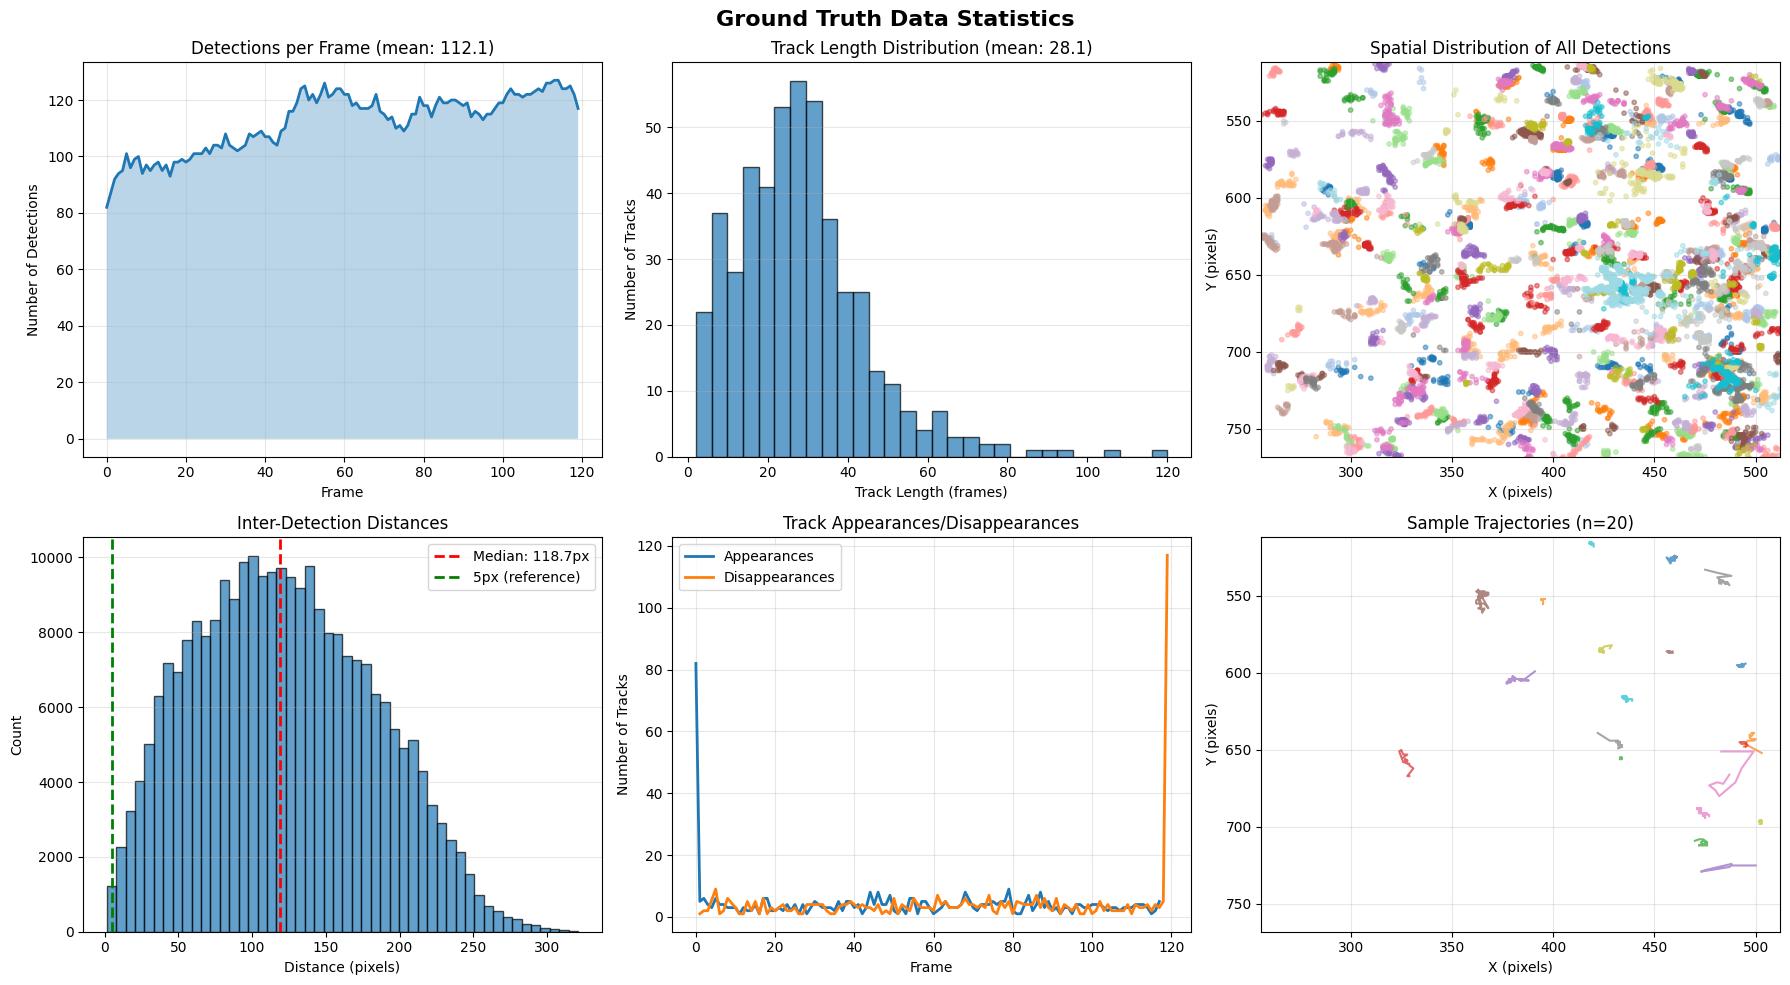


✓ Statistics saved to /content/benchmark_results_laptrack/gt_statistics.png


In [ ]:
# @title Visualize Ground Truth Statistics

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Ground Truth Data Statistics', fontsize=16, fontweight='bold')

# 1. Detections per frame
ax = axes[0, 0]
dets_per_frame = val_gt.groupby('frame').size()
ax.plot(dets_per_frame.index, dets_per_frame.values, linewidth=2)
ax.fill_between(dets_per_frame.index, dets_per_frame.values, alpha=0.3)
ax.set_xlabel('Frame')
ax.set_ylabel('Number of Detections')
ax.set_title(f'Detections per Frame (mean: {dets_per_frame.mean():.1f})')
ax.grid(True, alpha=0.3)

# 2. Track length distribution
ax = axes[0, 1]
track_lengths = val_gt.groupby('track_id').size()
ax.hist(track_lengths.values, bins=30, edgecolor='black', alpha=0.7)
ax.set_xlabel('Track Length (frames)')
ax.set_ylabel('Number of Tracks')
ax.set_title(f'Track Length Distribution (mean: {track_lengths.mean():.1f})')
ax.grid(True, alpha=0.3, axis='y')

# 3. Spatial distribution
ax = axes[0, 2]
scatter = ax.scatter(val_gt['x'], val_gt['y'], c=val_gt['track_id'],
                     cmap='tab20', alpha=0.5, s=10)
ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')
ax.set_title('Spatial Distribution of All Detections')
ax.set_xlim(roi['x_min'], roi['x_max'])
ax.set_ylim(roi['y_min'], roi['y_max'])
ax.invert_yaxis()
ax.grid(True, alpha=0.3)

# 4. Inter-detection distances
ax = axes[1, 0]
distances = []
for frame_idx in range(min(50, val_roi.shape[0])):  # Sample first 50 frames
    frame_dets = val_gt[val_gt['frame'] == frame_idx][['x', 'y']].values
    if len(frame_dets) > 1:
        dist_matrix = cdist(frame_dets, frame_dets)
        triu_indices = np.triu_indices_from(dist_matrix, k=1)
        distances.extend(dist_matrix[triu_indices])

if distances:
    ax.hist(distances, bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(np.median(distances), color='r', linestyle='--', linewidth=2,
               label=f'Median: {np.median(distances):.1f}px')
    ax.axvline(5, color='g', linestyle='--', linewidth=2, label='5px (reference)')
    ax.set_xlabel('Distance (pixels)')
    ax.set_ylabel('Count')
    ax.set_title('Inter-Detection Distances')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

# 5. Track appearances/disappearances
ax = axes[1, 1]
appearances = val_gt.groupby('track_id')['frame'].min().value_counts().sort_index()
disappearances = val_gt.groupby('track_id')['frame'].max().value_counts().sort_index()
ax.plot(appearances.index, appearances.values, label='Appearances', linewidth=2)
ax.plot(disappearances.index, disappearances.values, label='Disappearances', linewidth=2)
ax.set_xlabel('Frame')
ax.set_ylabel('Number of Tracks')
ax.set_title('Track Appearances/Disappearances')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Sample trajectories
ax = axes[1, 2]
sample_tracks = np.random.choice(val_gt['track_id'].unique(),
                                 size=min(20, val_gt['track_id'].nunique()), replace=False)
for track_id in sample_tracks:
    track_data = val_gt[val_gt['track_id'] == track_id].sort_values('frame')
    ax.plot(track_data['x'], track_data['y'], alpha=0.7, linewidth=1.5)
ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')
ax.set_title(f'Sample Trajectories (n={len(sample_tracks)})')
ax.set_xlim(roi['x_min'], roi['x_max'])
ax.set_ylim(roi['y_min'], roi['y_max'])
ax.invert_yaxis()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['OUTPUT_DIR'], 'gt_statistics.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Statistics saved to {CONFIG['OUTPUT_DIR']}/gt_statistics.png")

## Benchmark: LapTrack with Parameter Sweep

In [ ]:
# @title LapTrack Parameter Grid with Focused Distance Sweep

print("\n" + "="*70)
print("LAPTRACK BENCHMARK WITH FOCUSED DISTANCE SWEEP")
print("="*70)

# Define focused parameter grid based on prior knowledge
# Best known: track=7px, gap=5px, frames=2
# Note: LapTrack uses squared distances
laptrack_param_grid = {
    'track_cost_cutoff': [d**2 for d in CONFIG['SWEEP_TRACK_DISTANCES']],      # [25, 36, 49, 64]
    'gap_closing_cost_cutoff': [d**2 for d in CONFIG['SWEEP_GAP_DISTANCES']],  # [16, 25, 36, 49]
    'gap_closing_max_frame_count': CONFIG['SWEEP_GAP_FRAMES']                   # [1, 2, 3]
}

# Generate all combinations
param_keys = list(laptrack_param_grid.keys())
param_values = list(laptrack_param_grid.values())
param_combinations = list(itertools.product(*param_values))

print(f"Testing {len(param_combinations)} parameter combinations")
print(f"\nFocused parameter grid (centered on best known values):")
print(f"  track_cost_cutoff: {laptrack_param_grid['track_cost_cutoff']} → {CONFIG['SWEEP_TRACK_DISTANCES']}px")
print(f"  gap_closing_cost_cutoff: {laptrack_param_grid['gap_closing_cost_cutoff']} → {CONFIG['SWEEP_GAP_DISTANCES']}px")
print(f"  gap_closing_max_frame_count: {laptrack_param_grid['gap_closing_max_frame_count']}")

# Run benchmark
laptrack_results = []
best_laptrack_hota = 0.0
best_laptrack_params = None
best_laptrack_tracks = None

print(f"\nRunning LapTrack benchmark on GT detections...")
pbar = tqdm(param_combinations, desc="LapTrack")

for param_combo in pbar:
    params_dict = dict(zip(param_keys, param_combo))

    try:
        # Run tracking on GT detections
        tracks_df = track_with_laptrack(
            gt_detections_per_frame,
            track_cost_cutoff=params_dict['track_cost_cutoff'],
            gap_closing_cost_cutoff=params_dict['gap_closing_cost_cutoff'],
            gap_closing_max_frame_count=params_dict['gap_closing_max_frame_count']
        )

        if not tracks_df.empty:
            # Adjust coordinates back to full image
            tracks_df['x'] += roi['x_min']
            tracks_df['y'] += roi['y_min']

            # Evaluate against GT
            results = hota(val_gt, tracks_df)

            # Add distance info (square root for display)
            result_entry = {
                'method': 'laptrack',
                'track_distance_px': np.sqrt(params_dict['track_cost_cutoff']),
                'gap_distance_px': np.sqrt(params_dict['gap_closing_cost_cutoff']),
                **params_dict,
                **results
            }
            laptrack_results.append(result_entry)

            # Update best
            if results['HOTA'] > best_laptrack_hota:
                best_laptrack_hota = results['HOTA']
                best_laptrack_params = params_dict
                best_laptrack_tracks = tracks_df.copy()

                pbar.set_postfix({
                    'Best HOTA': f"{best_laptrack_hota:.4f}",
                    'DetA': f"{results['DetA']:.4f}",
                    'AssA': f"{results['AssA']:.4f}"
                })
        else:
            result_entry = {
                'method': 'laptrack',
                'track_distance_px': np.sqrt(params_dict['track_cost_cutoff']),
                'gap_distance_px': np.sqrt(params_dict['gap_closing_cost_cutoff']),
                **params_dict,
                'HOTA': 0.0, 'DetA': 0.0, 'AssA': 0.0, 'LocA': 0.0,
                'HOTA TP': 0, 'HOTA FN': 0, 'HOTA FP': 0
            }
            laptrack_results.append(result_entry)

    except Exception as e:
        pbar.write(f"Error with params {params_dict}: {e}")
        continue

# Convert to DataFrame
laptrack_results_df = pd.DataFrame(laptrack_results)

print(f"\n" + "="*70)
print("LAPTRACK BEST RESULT")
print("="*70)
if best_laptrack_params:
    best_lap_result = laptrack_results_df.loc[laptrack_results_df['HOTA'].idxmax()]
    print(f"HOTA: {best_lap_result['HOTA']:.4f}")
    print(f"DetA: {best_lap_result['DetA']:.4f}")
    print(f"AssA: {best_lap_result['AssA']:.4f}")
    print(f"\nBest parameters:")
    print(f"  track_cost_cutoff: {best_laptrack_params['track_cost_cutoff']} (√={np.sqrt(best_laptrack_params['track_cost_cutoff']):.1f}px)")
    print(f"  gap_closing_cost_cutoff: {best_laptrack_params['gap_closing_cost_cutoff']} (√={np.sqrt(best_laptrack_params['gap_closing_cost_cutoff']):.1f}px)")
    print(f"  gap_closing_max_frame_count: {best_laptrack_params['gap_closing_max_frame_count']}")
else:
    print("No valid results found!")
print("="*70)

## Visualizations

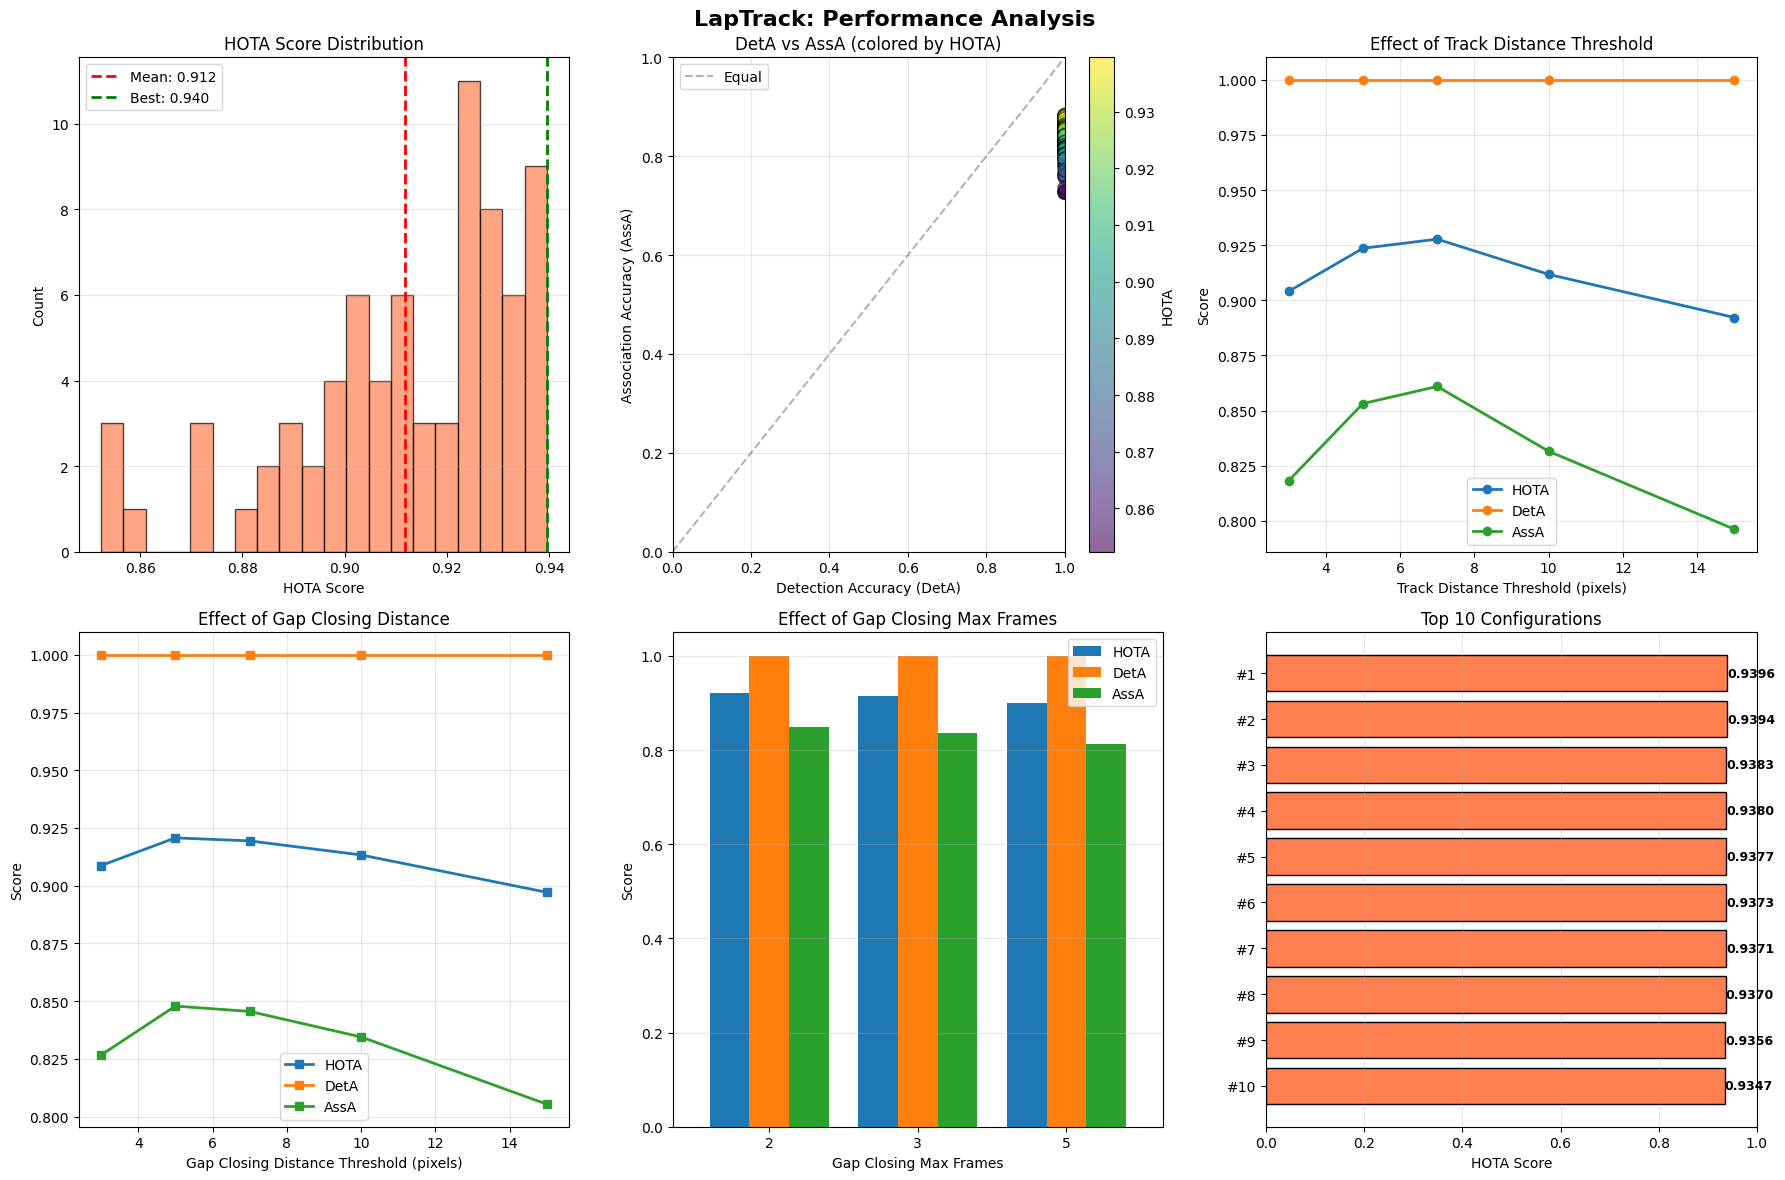


✓ Performance analysis saved to /content/benchmark_results_laptrack/performance_analysis.png


In [ ]:
# @title Performance Analysis Plots

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('LapTrack: Performance Analysis', fontsize=16, fontweight='bold')

# 1. HOTA Distribution
ax = axes[0, 0]
ax.hist(laptrack_results_df['HOTA'], bins=20, edgecolor='black', alpha=0.7, color='coral')
ax.axvline(laptrack_results_df['HOTA'].mean(), color='r', linestyle='--',
           linewidth=2, label=f'Mean: {laptrack_results_df["HOTA"].mean():.3f}')
ax.axvline(laptrack_results_df['HOTA'].max(), color='g', linestyle='--',
           linewidth=2, label=f'Best: {laptrack_results_df["HOTA"].max():.3f}')
ax.set_xlabel('HOTA Score')
ax.set_ylabel('Count')
ax.set_title('HOTA Score Distribution')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 2. DetA vs AssA Scatter
ax = axes[0, 1]
scatter = ax.scatter(laptrack_results_df['DetA'], laptrack_results_df['AssA'],
                     c=laptrack_results_df['HOTA'], cmap='viridis',
                     s=100, alpha=0.6, edgecolors='black')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Equal')
ax.set_xlabel('Detection Accuracy (DetA)')
ax.set_ylabel('Association Accuracy (AssA)')
ax.set_title('DetA vs AssA (colored by HOTA)')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.legend()
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='HOTA')

# 3. Track Distance Effect
ax = axes[0, 2]
track_dist_effect = laptrack_results_df.groupby('track_distance_px')[['HOTA', 'DetA', 'AssA']].mean()
track_dist_effect.plot(ax=ax, marker='o', linewidth=2)
ax.set_xlabel('Track Distance Threshold (pixels)')
ax.set_ylabel('Score')
ax.set_title('Effect of Track Distance Threshold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# 4. Gap Closing Distance Effect
ax = axes[1, 0]
gap_dist_effect = laptrack_results_df.groupby('gap_distance_px')[['HOTA', 'DetA', 'AssA']].mean()
gap_dist_effect.plot(ax=ax, marker='s', linewidth=2)
ax.set_xlabel('Gap Closing Distance Threshold (pixels)')
ax.set_ylabel('Score')
ax.set_title('Effect of Gap Closing Distance')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# 5. Gap Closing Frames Effect
ax = axes[1, 1]
gap_frames_effect = laptrack_results_df.groupby('gap_closing_max_frame_count')[['HOTA', 'DetA', 'AssA']].mean()
gap_frames_effect.plot(kind='bar', ax=ax, width=0.8)
ax.set_xlabel('Gap Closing Max Frames')
ax.set_ylabel('Score')
ax.set_title('Effect of Gap Closing Max Frames')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(loc='best')
ax.grid(True, alpha=0.3, axis='y')

# 6. Top 10 Configurations
ax = axes[1, 2]
top_10 = laptrack_results_df.nlargest(10, 'HOTA')
bars = ax.barh(range(10), top_10['HOTA'].values, color='coral', edgecolor='black')
ax.set_yticks(range(10))
ax.set_yticklabels([f"#{i+1}" for i in range(10)])
ax.set_xlabel('HOTA Score')
ax.set_title('Top 10 Configurations')
ax.invert_yaxis()
ax.set_xlim([0, 1])
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
            f'{width:.4f}', ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['OUTPUT_DIR'], 'performance_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Performance analysis saved to {CONFIG['OUTPUT_DIR']}/performance_analysis.png")

##  Save Results

In [ ]:
# @title Save Results to Files

if CONFIG['SAVE_CSV']:
    print("\nSaving results to files...")

    # Save all results
    all_results_path = os.path.join(CONFIG['OUTPUT_DIR'], 'laptrack_results.csv')
    laptrack_results_df.to_csv(all_results_path, index=False)
    print(f"✓ All results saved to {all_results_path}")

    # Save summary
    summary_path = os.path.join(CONFIG['OUTPUT_DIR'], 'laptrack_summary.txt')
    with open(summary_path, 'w') as f:
        f.write("LAPTRACK BENCHMARK SUMMARY (GROUND TRUTH DATA)\n")
        f.write("="*70 + "\n\n")
        f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Data source: Ground Truth Detections\n")
        f.write(f"Sweep distances: {CONFIG['SWEEP_DISTANCES']}px\n\n")

        f.write("GROUND TRUTH STATISTICS:\n")
        f.write(f"  Total detections: {len(val_gt)}\n")
        f.write(f"  Total tracks: {val_gt['track_id'].nunique()}\n")
        f.write(f"  Frames: {val_roi.shape[0]}\n")
        f.write(f"  Average detections per frame: {len(val_gt) / val_roi.shape[0]:.1f}\n\n")

        f.write("BEST LAPTRACK RESULT:\n")
        best_lap = laptrack_results_df.loc[laptrack_results_df['HOTA'].idxmax()]
        f.write(f"  HOTA: {best_lap['HOTA']:.4f}\n")
        f.write(f"  DetA: {best_lap['DetA']:.4f}\n")
        f.write(f"  AssA: {best_lap['AssA']:.4f}\n")
        if best_laptrack_params:
            f.write(f"  Parameters:\n")
            f.write(f"    track_cost_cutoff: {best_laptrack_params['track_cost_cutoff']} (√={np.sqrt(best_laptrack_params['track_cost_cutoff']):.1f}px)\n")
            f.write(f"    gap_closing_cost_cutoff: {best_laptrack_params['gap_closing_cost_cutoff']} (√={np.sqrt(best_laptrack_params['gap_closing_cost_cutoff']):.1f}px)\n")
            f.write(f"    gap_closing_max_frame_count: {best_laptrack_params['gap_closing_max_frame_count']}\n")
        f.write("\n")

        f.write("STATISTICS SUMMARY:\n")
        summary = laptrack_results_df[['HOTA', 'DetA', 'AssA']].describe()
        f.write(summary.to_string())

    print(f"✓ Summary saved to {summary_path}")

    # Save best tracks
    if best_laptrack_tracks is not None:
        tracks_path = os.path.join(CONFIG['OUTPUT_DIR'], 'best_laptrack_tracks.csv')
        best_laptrack_tracks.to_csv(tracks_path, index=False)
        print(f"✓ Best tracks saved to {tracks_path}")
else:
    print("\nSkipping file save")

print("\n" + "="*70)
print(" BENCHMARK COMPLETE!")
print("="*70)
print(f"\n Results saved to: {CONFIG['OUTPUT_DIR']}/")
print(f"    ├── laptrack_results.csv")
print(f"    ├── laptrack_summary.txt")
print(f"    ├── best_laptrack_tracks.csv")
print(f"    ├── gt_statistics.png")
print(f"    └── performance_analysis.png")
print("\n" + "="*70)


Saving results to files...
✓ All results saved to /content/benchmark_results_laptrack/laptrack_results.csv
✓ Summary saved to /content/benchmark_results_laptrack/laptrack_summary.txt
✓ Best tracks saved to /content/benchmark_results_laptrack/best_laptrack_tracks.csv

 BENCHMARK COMPLETE!

 Results saved to: /content/benchmark_results_laptrack/
    ├── laptrack_results.csv
    ├── laptrack_summary.txt
    ├── best_laptrack_tracks.csv
    ├── gt_statistics.png
    └── performance_analysis.png

